In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import Adam

In [5]:
df = pd.read_csv('Normalized_WT5.txt', delimiter=r'\s+', quotechar='"')
print(df.head())

   Sequence No.         V         D  air density   Humidity         I  \
0             1  6.873766  174.0575     1.219331  50.082808  0.021919   
1             2  7.096613  176.4439     1.219144  48.541693  0.037737   
2             3  8.101572  176.3133     1.218397  46.252931  0.049063   
3             4  8.762237  181.0317     1.219514  47.099364  0.094166   
4             5  9.901171  183.5434     1.216877  44.129409  0.027735   

        S_a       S_b  y (% relative to rated power)  
0  0.110258  0.135261                      11.653333  
1  0.061554  0.156136                      30.550000  
2  0.152517  0.223355                      43.850000  
3  0.254332  0.256441                      51.660000  
4  0.073538  0.311642                      46.406667  


In [6]:
data_size = 1440
data = df.drop(columns = 'Sequence No.')[:data_size]
data_target = df['y (% relative to rated power)'][:data_size]

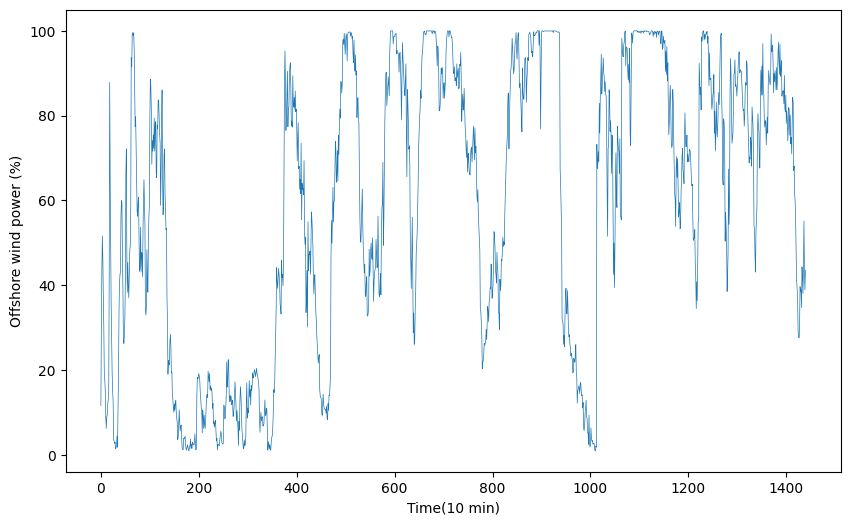

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(data_target, linewidth=0.5)
plt.ylabel('Offshore wind power (%)')
plt.xlabel('Time(10 min)')
plt.show()

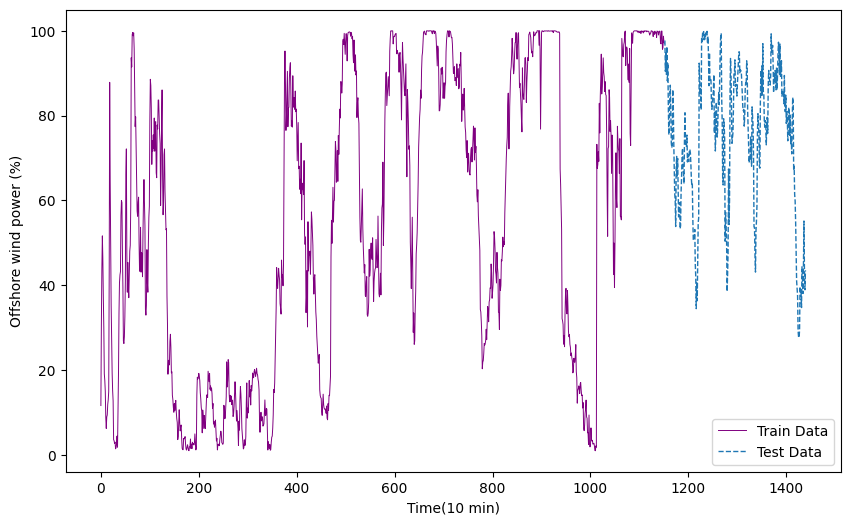

In [ ]:
test_indexes = range(int(data_size * 0.8), int(data_size * 0.8 + data_size * 0.2))
train_indexes = range(int(data_size * 0.8))
plt.figure(figsize=(10,6))
plt.plot(train_indexes, data_target[train_indexes], color='purple' , label='Train Data', linewidth=0.7)
plt.plot(test_indexes, data_target[test_indexes], label='Test Data', linestyle='--', linewidth=1)
plt.ylabel('Offshore wind power (%)')
plt.xlabel('Time(10 min)')
plt.legend()
plt.show()


Outlier Detection

In [ ]:
def detect_outlier(data):
    outliers = []
    for i in range(len(data)):
        windowed_data = np.concatenate((data[i-24:i], data[i+1:i+24]))
        window_mean = np.mean(windowed_data)
        window_var = np.var(windowed_data)
        if data[i] > window_mean + 1 * np.sqrt(window_var) or data[i] < window_mean - 1 * np.sqrt(window_var):
            outliers.append(i)
    return outliers

outliers = detect_outlier(data_target.values)

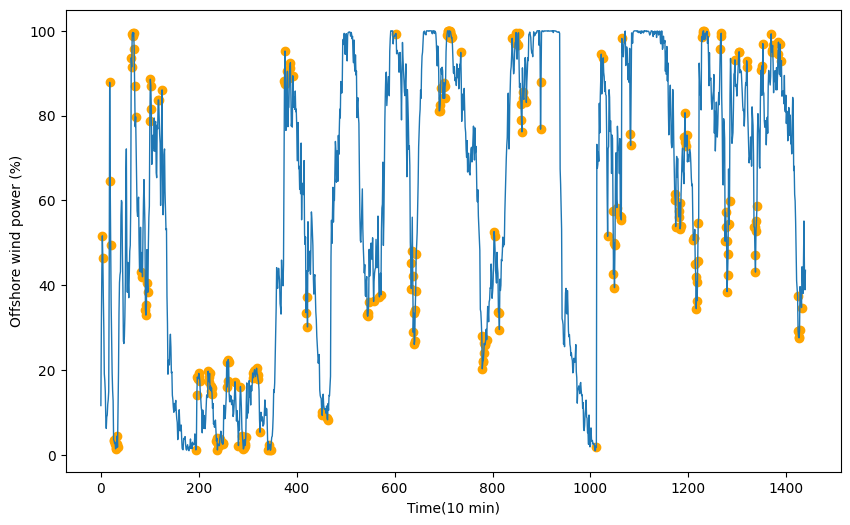

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(data_target, linewidth=1)
plt.scatter(outliers, [data_target[i] for i in outliers], color='orange', label='Outliers')
plt.ylabel('Offshore wind power (%)')
plt.xlabel('Time(10 min)')
plt.show()

Denoising with Autoencoder

In [7]:
def autoencoder(input_shape=(1440, 8)):
    model = Sequential()
    model.add(layers.Dense(512, activation='relu'))

    model.add(layers.Dense(256, activation='relu'))

    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(input_shape[1], activation='linear'))

    return model

autoencoder = autoencoder()
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
autoencoder.fit(data.values.reshape(1, 1440, 8), data.values.reshape(1, 1440, 8), epochs=40, batch_size=1)

denoised_data = autoencoder.predict(data.values.reshape(1, 1440, 8))
denoised_data = denoised_data[0]

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 5692.0811
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 4339.2925
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3141.8474
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 2014.2413
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 1024.2278
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 389.9341
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 377.4058
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 814.6151
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1025.0159
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 859.9460
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 551.2891
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 298.9851
Epoch 13/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 177.9690
Epoch 14/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 171.8644
Epoch 15/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 228

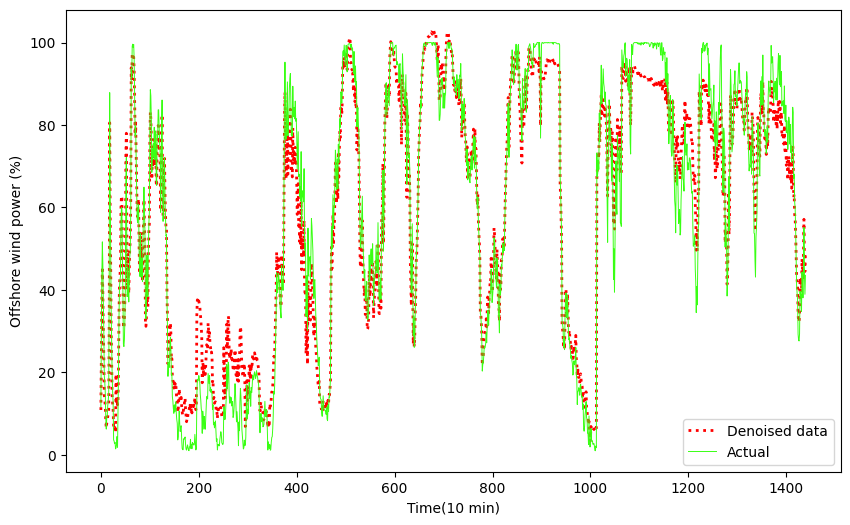

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(denoised_data[:,7],  linestyle=':', linewidth=2, color = 'red', label='Denoised data')
plt.plot(data_target, linewidth=0.7, color = '#39FF14', label='Actual')
plt.ylabel('Offshore wind power (%)')
plt.xlabel('Time(10 min)')
plt.legend()
plt.show()

Preprocessing the Data

In [8]:
data = denoised_data#[:,7].reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(data)

In [9]:
one_day_periods = 144
single_step = 1
X = []
y = []

for i in range(data_size - one_day_periods - single_step + 1):
    X.append(normalized_data[i:i + one_day_periods])
    y.append(normalized_data[i + one_day_periods:i + one_day_periods + single_step,data.shape[1]-1])

X = np.array(X)
y = np.array(y)


In [10]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Metrics and Loss Functions

In [ ]:
def mae(prediction, real):
    return np.mean(np.abs(prediction - real))
def rmse(prediction, real):
    return np.sqrt(np.mean((prediction - real)**2))
def rsqured(prediction, real):
    return 1 - (np.sum((real - prediction)**2) / np.sum((real - np.mean(real))**2))
def mape(prediction, real):
    return np.mean(np.abs((real - prediction) / real))
def huber_loss(prediction, real, delta=1.0):
    square_loss = tf.square(prediction - real)
    abs_loss = tf.abs(prediction - real)
    return tf.where(abs_loss <= delta, 0.5 * square_loss, delta * abs_loss - 0.5 * delta ** 2)


Models Implementation

In [ ]:
def rnn(input_shape):
    model = Sequential()
    model.add(SimpleRNN(units=64, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(SimpleRNN(units=32, activation='relu'))
    model.add(layers.Dense(units=1))

    return model

In [ ]:
def mlp(input_shape):
    model = Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(units=1))

    return model

In [11]:
def transformer(input_shape):
    input = layers.Input(shape=input_shape)
    x = layers.Dense(32, activation='relu')(input)
    X = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Flatten()(x)
    output = layers.Dense(1)(x)

    model = models.Model(inputs=input, outputs=output)

    return model

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
model_rnn_mse = rnn(input_shape)
model_rnn_mse.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model_rnn_mse.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.2279
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0064
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0042
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0037
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0029
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0033
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0037
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0030
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0027
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0022
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0034
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0027
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0025
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0023
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0025
Epoch 16/50
33/

In [ ]:
model_rnn_huber = rnn(input_shape)
model_rnn_huber.compile(optimizer=Adam(learning_rate=0.001), loss=huber_loss)
model_rnn_huber.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0902
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0025
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0021
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0015
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0013
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0015
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0013
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0013
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0011
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0011
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0013
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0010
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0015
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0010
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0013
Epoc

In [ ]:
model_mlp_huber = mlp(input_shape)
model_mlp_huber.compile(optimizer=Adam(learning_rate=0.001), loss=huber_loss)
model_mlp_huber.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0965
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0115  
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047 
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042 
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036 
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026
Epoch

In [ ]:
model_mlp_mse = mlp(input_shape)
model_mlp_mse.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model_mlp_mse.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1463
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0127
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0046 
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037 
Epoch 16/50
33/

In [ ]:
model_transformer_huber = transformer(input_shape)
model_transformer_huber.compile(optimizer=Adam(learning_rate=0.001), loss=huber_loss)
model_transformer_huber.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0742
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162  
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049 
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032 
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 
Epoch 16

In [ ]:
model_transformer_mse = transformer(input_shape)
model_transformer_mse.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model_transformer_mse.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1255
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0281   
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142 
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0097 
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0079 
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0058 
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0042
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 16/5

In [ ]:
rnn_huber_predictions = model_rnn_huber.predict(X_test)
rnn_mse_predictions = model_rnn_mse.predict(X_test)
mlp_huber_predictions = model_mlp_huber.predict(X_test)
mlp_mse_predictions = model_mlp_mse.predict(X_test)
transformer_huber_predictions = model_transformer_huber.predict(X_test)
transformer_mse_predictions = model_transformer_mse.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


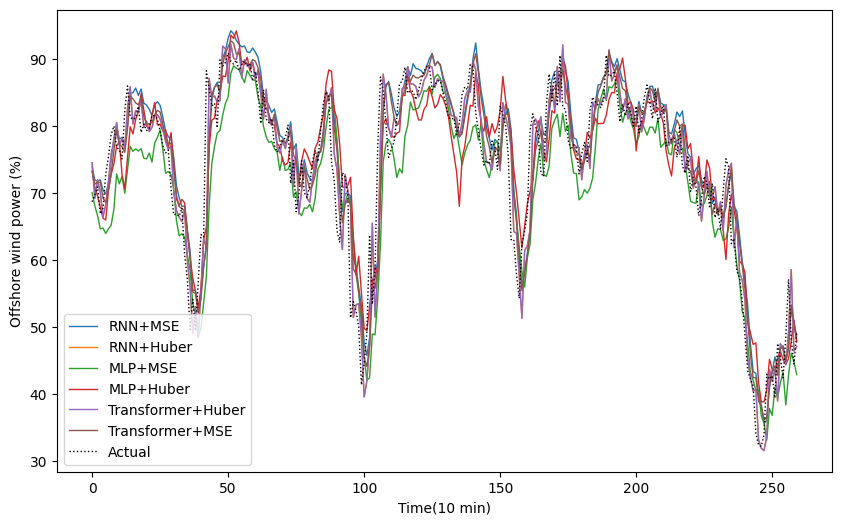

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(rnn_mse_predictions.reshape(-1, 1)), label = 'RNN+MSE', linewidth=1)
plt.plot(scaler.inverse_transform(rnn_huber_predictions.reshape(-1, 1)), label='RNN+Huber', linewidth=1)
plt.plot(scaler.inverse_transform(mlp_mse_predictions.reshape(-1, 1)), label = 'MLP+MSE', linewidth=1)
plt.plot(scaler.inverse_transform(mlp_huber_predictions.reshape(-1, 1)), label='MLP+Huber', linewidth=1)
plt.plot(scaler.inverse_transform(transformer_huber_predictions.reshape(-1, 1)), label='Transformer+Huber', linewidth=1)
plt.plot(scaler.inverse_transform(transformer_mse_predictions.reshape(-1, 1)), label='Transformer+MSE', linewidth=1)
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual', linewidth=1,linestyle=':', color='k' )
plt.legend()
plt.ylabel('Offshore wind power (%)')
plt.xlabel('Time(10 min)')
plt.show()

In [ ]:
def calc_metrics(prediction, real, scaler):
      prediction = scaler.inverse_transform(prediction)
      real = scaler.inverse_transform(real.reshape(-1, 1))
      mae_val = mae(prediction, real)
      rmse_val = rmse(prediction, real)
      rsqured_val = rsqured(prediction, real)
      mape_val = mape(prediction, real)
      return mae_val, rmse_val, rsqured_val, mape_val

In [ ]:
rnn_huber_metrics = calc_metrics(rnn_huber_predictions, y_test, scaler)
rnn_mse_metrics = calc_metrics(rnn_mse_predictions, y_test, scaler)
mlp_huber_metrics = calc_metrics(mlp_huber_predictions.reshape(-1,1), y_test, scaler)
mlp_mse_metrics = calc_metrics(mlp_mse_predictions.reshape(-1,1), y_test, scaler)
transformer_huber_metrics = calc_metrics(transformer_huber_predictions.reshape(-1,1), y_test, scaler)
transformer_mse_metrics = calc_metrics(transformer_mse_predictions.reshape(-1,1), y_test, scaler)

metrics = {
    'Metric': ['MAE', ' ', ' ', 'MAPE', ' ', ' ', 'RMSE', ' ', ' ', 'R²', ' ', ' '],
    'Model': ['MLP', 'RNN', 'Transformer', 'MLP', 'RNN', 'Transformer', 'MLP', 'RNN', 'Transformer', 'MLP', 'RNN', 'Transformer'],
    'Huber': [
        mlp_huber_metrics[0], rnn_huber_metrics[0], transformer_huber_metrics[0],
        mlp_huber_metrics[3], rnn_huber_metrics[3], transformer_huber_metrics[3],
        mlp_huber_metrics[1], rnn_huber_metrics[1], transformer_huber_metrics[1],
        mlp_huber_metrics[2], rnn_huber_metrics[2], transformer_huber_metrics[2]
    ],
    'MSE': [
        mlp_mse_metrics[0], rnn_mse_metrics[0], transformer_mse_metrics[0],
        mlp_mse_metrics[3], rnn_mse_metrics[3], transformer_mse_metrics[3],
        mlp_mse_metrics[1], rnn_mse_metrics[1], transformer_mse_metrics[1],
        mlp_mse_metrics[2], rnn_mse_metrics[2], transformer_mse_metrics[2]
    ]
}


metrics_df = pd.DataFrame(metrics)
print(metrics_df)

   Metric        Model     Huber       MSE
0     MAE          MLP  4.389891  4.933695
1                  RNN  3.404903  3.393491
2          Transformer  3.236347  3.364571
3    MAPE          MLP  0.064976  0.069694
4                  RNN  0.049871  0.049658
5          Transformer  0.043950  0.048547
6    RMSE          MLP  5.890296  6.723701
7                  RNN  4.867794  4.827840
8          Transformer  4.003928  4.210677
9      R²          MLP  0.801819  0.741771
10                 RNN  0.864652  0.866865
11         Transformer  0.920620  0.878903


Slime Mould

In [44]:
def transformer_for_sma(input_shape, embedding_dim, num_heads, hidden_units):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Dense(embedding_dim, activation='relu')(input_layer)
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(hidden_units[0], activation='relu')(x)
    x = layers.Dense(hidden_units[1], activation='relu')(x)
    x = layers.Flatten()(x)
    output = layers.Dense(1)(x)
    model = models.Model(inputs=input_layer, outputs=output)
    return model
def objective_function(params, X_train, y_train, X_val, y_val):
    model = transformer_for_sma((X_train.shape[1], X_train.shape[2]), int(params[0]), int(params[1]), [int(params[2]), int(params[3])])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=["mae"])
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=32, verbose=0)
    return model.evaluate(X_val, y_val, verbose=0)[0]

In [45]:
def slime_mould(objective_function, bounds, dim, num_agents, max_iter, X_train, y_train, X_val, y_val):
    agents = np.random.rand(num_agents, dim)
    for i in range(dim):
        agents[:, i] = bounds[i][0] + agents[:, i] * (bounds[i][1] - bounds[i][0]) 
    best_score = np.inf

    for iter in range(max_iter):
        print('running iteration', iter)
        fitness = np.array([objective_function(agent, X_train, y_train, X_val, y_val) for agent in agents])
        if np.min(fitness) < best_score:
            best_score = np.min(fitness)
            best_agent = agents[np.argmin(fitness)]

        w = 2 * (1 - (fitness - np.min(fitness)) / (np.max(fitness) - np.min(fitness)))
        a = np.tanh(1 -iter / max_iter)

        for i in range(num_agents):
            for d in range(dim):
                r = np.random.uniform(0, 1)
                if r < a:
                    agents[i, d] += a * w[i] * (agents[i, d] - best_agent[d])
                else:
                    agents[i, d] += a * (np.random.uniform(bounds[d][0], bounds[d][1]) - agents[i, d])

    return best_agent

In [46]:
#optimizing embedding dimention, number of multi head attention heads, and hidden units for both the layers
num_agents = 10
dimention = 4
num_iterations = 10
bounds = [(16, 64), (2, 8),(32, 128),(16, 64)]
optimized_parameters = slime_mould(objective_function, bounds, dimention, num_agents, num_iterations, X_train, y_train, X_test, y_test)

print("Best embedding dimention:", (optimized_parameters[0]))
print("Best number of multi head attention heads:", (optimized_parameters[1]))
print("Best number of hidden units for the first layer:", (optimized_parameters[2]))
print("Best number of hidden units for the second layer:", (optimized_parameters[3]))

running iteration 0
running iteration 1
running iteration 2
running iteration 3
running iteration 4
running iteration 5
running iteration 6
running iteration 7
running iteration 8
running iteration 9
Best embedding dimention: 42.843570774310216
Best number of multi head attention heads: 5.499685419654791
Best number of hidden units for the first layer: 95.86817810915583
Best number of hidden units for the second layer: 42.22920822753381


In [47]:
print("Best embedding dimention:", int(optimized_parameters[0]))
print("Best number of multi head attention heads:", int(optimized_parameters[1]))
print("Best number of hidden units for the first layer:", int(optimized_parameters[2]))
print("Best number of hidden units for the second layer:", int(optimized_parameters[3]))

Best embedding dimention: 42
Best number of multi head attention heads: 5
Best number of hidden units for the first layer: 95
Best number of hidden units for the second layer: 42


Multi-Step

In [ ]:
one_day_periods = 144
four_hour_periods = 24
X = []
y = []

for i in range(data_size - one_day_periods - four_hour_periods + 1):
    X.append(normalized_data[i:i + one_day_periods])
    y.append(normalized_data[i + one_day_periods:i + one_day_periods + four_hour_periods, data.shape[1] - 1])

X = np.array(X)
X = X.reshape(X.shape[0], X.shape[1], 1)
y = np.array(y)

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
def transformer_multi(input_shape):

    input = layers.Input(shape=input_shape)
    x = layers.Dense(32, activation='relu')(input)
    x = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)

    x = layers.Flatten()(x)
    output = layers.Dense(24)(x)
    output = layers.Reshape((24, 1))(output)

    model = models.Model(inputs=input, outputs=output)
    return model

In [ ]:
transformer_model = transformer_multi(input_shape=(X_train.shape[1], 1))
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
transformer_model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 0.1800
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0783
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0586
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0444
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0414
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0365
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0351
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0351
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0345
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0343
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0304
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0289
Epoch 16/50
32/32 

In [ ]:
transformer_model_huber = transformer_multi(input_shape=(X_train.shape[1], 1))
transformer_model_huber.compile(optimizer=Adam(learning_rate=0.001), loss=huber_loss)
transformer_model_huber.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0851
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0346
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0257
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0223
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0160
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141
Epoch 16/50
32/32 

In [ ]:
transformer_mse_predictions = transformer_model.predict(X_test)
transformer_mse_predictions_huber = transformer_model_huber.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


In [ ]:
predict_four_mse = transformer_mse_predictions[4:, 1, 0]
predict_eight_mse = transformer_mse_predictions[7:, 7, 0]
predict_sixteen_mse = transformer_mse_predictions[15:, 15, 0]
predict_four_huber = transformer_mse_predictions_huber[4:, 1, 0]
predict_eight_huber = transformer_mse_predictions_huber[7:, 7, 0]
predict_sixteen_huber = transformer_mse_predictions_huber[15:, 15, 0]

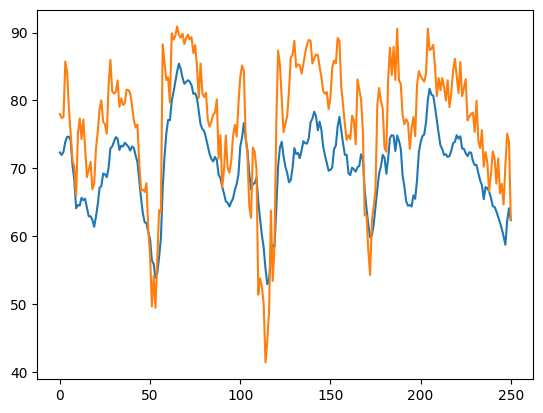

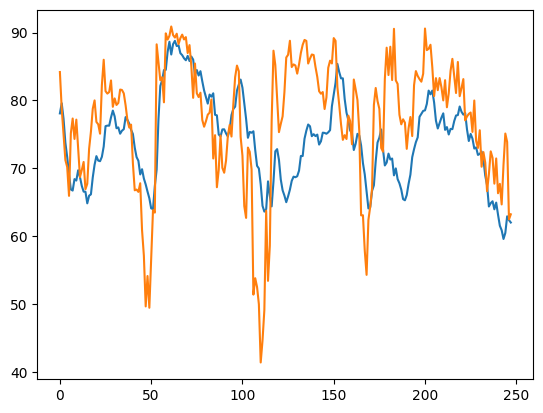

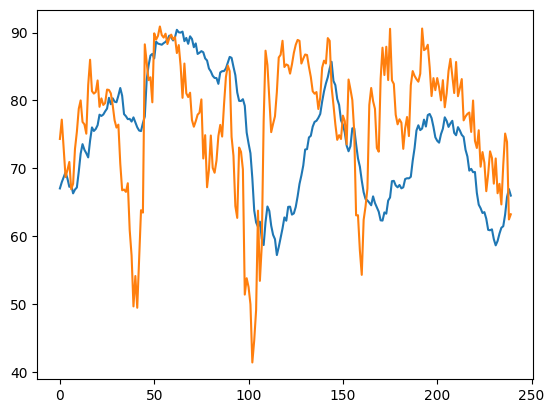

In [ ]:
y_test_descaled_four = scaler.inverse_transform(y_test[:-4, 3].reshape(-1, 1))
y_test_descaled_eight = scaler.inverse_transform(y_test[:-7 ,7].reshape(-1, 1))
y_test_descaled_sixteen = scaler.inverse_transform(y_test[:-15, 15].reshape(-1, 1))

plt.plot(scaler.inverse_transform(predict_four_mse.reshape(-1, 1)))
plt.plot(y_test_descaled_four)
plt.show()
plt.plot(scaler.inverse_transform(predict_eight_mse.reshape(-1, 1)))
plt.plot(y_test_descaled_eight)
plt.show()
plt.plot(scaler.inverse_transform(predict_sixteen_mse.reshape(-1, 1)))
plt.plot(y_test_descaled_sixteen)

In [ ]:
four_mse_metrics = calc_metrics(predict_four_mse.reshape(-1, 1), y_test[:-4, 3].reshape(-1, 1), scaler)
eight_mse_metrics = calc_metrics(predict_eight_mse.reshape(-1, 1), y_test[:-7, 7].reshape(-1, 1), scaler)
sixteen_mse_metrics = calc_metrics(predict_sixteen_mse.reshape(-1, 1), y_test[:-15, 15].reshape(-1, 1), scaler)
four_huber_metrics = calc_metrics(predict_four_huber.reshape(-1, 1), y_test[:-4, 3].reshape(-1, 1), scaler)
eight_huber_metrics = calc_metrics(predict_eight_huber.reshape(-1, 1), y_test[:-7, 7].reshape(-1, 1), scaler)
sixteen_huber_metrics = calc_metrics(predict_sixteen_huber.reshape(-1, 1), y_test[:-15, 15].reshape(-1, 1), scaler)

metrics = {
    'Time': ['t+4',' ', ' ', 't+8',' ',' ', 't+16',' ',' '],
    'Index': ['MAE', 'MAPE', 'RMSE', 'MAE', 'MAPE', 'RMSE','MAE', 'MAPE', 'RMSE'],
    'Huber': [
        four_huber_metrics[0], four_huber_metrics[3], four_huber_metrics[1],
        eight_huber_metrics[0], eight_huber_metrics[3], eight_huber_metrics[1],
        sixteen_huber_metrics[0], sixteen_huber_metrics[3], sixteen_huber_metrics[1],
    ],
    'MSE': [
        four_mse_metrics[0], four_mse_metrics[3], four_mse_metrics[1],
        eight_mse_metrics[0], eight_mse_metrics[3], eight_mse_metrics[1],
        sixteen_mse_metrics[0], sixteen_mse_metrics[3], sixteen_mse_metrics[1],
    ]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

   Time Index      Huber        MSE
0   t+4   MAE   3.010949   7.636611
1        MAPE   0.041679   0.098233
2        RMSE   3.864306   8.511173
3   t+8   MAE   4.858169   6.874959
4        MAPE   0.067122   0.093679
5        RMSE   6.217847   8.752306
6  t+16   MAE   8.473913   9.494337
7        MAPE   0.111671   0.129687
8        RMSE  10.093226  11.787048
